In [1]:
!python3 -m pip install tensorflow==2.9.1

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)


In [153]:
import os
import cv2
import time
import glob
import shutil
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D
print ('modules loaded')

modules loaded


In [154]:
print(tf.__version__)

2.9.1


In [155]:
import os
images_dir = os.path.join('myyy_Test')

In [156]:
data_dir = images_dir

In [157]:
# from keras.preprocessing.image import ImageDataGenerator
# import os

# # Define the data augmentation parameters
# augmentation = ImageDataGenerator(
#     rotation_range=10, # rotate images by up to 10 degrees
#     width_shift_range=0.1, # shift images horizontally by up to 10% of the width
#     height_shift_range=0.1, # shift images vertically by up to 10% of the height
#     shear_range=0.1, # apply shearing transformations
#     zoom_range=0.1, # zoom in or out on images by up to 10%
#     horizontal_flip=True, # flip images horizontally
#     fill_mode='nearest' # fill in any gaps created by the transformations with the nearest pixel value
# )

# # Load the images from a directory
# image_directory = os.path.join('myyy_Test', 'validate', 's_kidney_clearcell')
# image_files = os.listdir(image_directory)

In [158]:
# aug_images = []
# i = 0
# # Loop through the images and apply data augmentation to them
# for image_file in image_files:
#     # Load the image
# #     if i > 34:
# #         break
#     i += 1
#     image_path = os.path.join(image_directory, image_file)
#     from PIL import Image
#     image = np.array(Image.open(image_path))
# #     image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

#     # Apply data augmentation to the image
#     augmented_images = augmentation.flow(
#         x=image.reshape((1,) + image.shape), # reshape the image to have a batch size of 1
#         batch_size=1,
#         save_to_dir=image_directory, # save the augmented images to the same directory
#         save_prefix=image_file[:-4], # use the original filename as the prefix for the augmented images
#         save_format='png'
#     )
    
#     # Generate the augmented images and save them to the directory
#     for i in range(7): # generate 5 augmented images per original image
#         augmented_image = next(augmented_images)[0].astype('uint8')
#         augmented_image_path = os.path.join(image_directory, f'{image_file[:-4]}_aug_{i}.jpg')
#         augmented_image = Image.fromarray(augmented_image)
#         aug_images.append({"image": augmented_image, "path": augmented_image_path})
#         # Save the augmented image to a file
# #         augmented_image.save(augmented_image_path)


In [167]:
import os
import pandas as pd

# define the directory structure
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'validate')
test_dir = os.path.join(data_dir, 'test')

# define the class names
# class_names = ['colon_n', 'colon_aca', 'gastric_aca', 'gastric_n', 'kidney Chromophobe carcinoma', 'kidney clear cell carinoma', 'kidney papillary carcinoma']
# class_names = ['colon_n', 'colon_aca', 'gastric_aca', 'gastric_n', 's_kidney_clearcell', 's_kidney_oncocytoma', 's_kidney_papillary']
class_names = ['colon_n', 'colon_aca', 'gastric_aca', 'gastric_n', 's_kidney_clearcell', 's_kidney_n']

target_names = class_names

# create a dataframe for the train data
train_data = []
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        train_data.append((img_path, class_name))
train_df = pd.DataFrame(train_data, columns=['filepaths', 'labels'])

# create a dataframe for the validation data
valid_data = []
for class_name in class_names:
    class_dir = os.path.join(valid_dir, class_name)
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        valid_data.append((img_path, class_name))
valid_df = pd.DataFrame(valid_data, columns=['filepaths', 'labels'])

# create a dataframe for the test data
test_data = []
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        test_data.append((img_path, class_name))
test_df = pd.DataFrame(test_data, columns=['filepaths', 'labels'])


In [168]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
class_weight='balanced', classes=np.unique(train_df['labels']), y=train_df['labels'])

# Data Preprocessing
# Data Generator with Data Augmentaion
batch_size = 40
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)


Found 6025 validated image filenames belonging to 6 classes.
Found 657 validated image filenames belonging to 6 classes.
Found 662 validated image filenames belonging to 6 classes.


In [169]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

In [170]:
# partial transfusion

base_model.trainable = True
for layer in base_model.layers:
        layer.trainable = False
        if isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = True
            layer.momentum = 0.99

In [171]:
model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_10 (Bat  (None, 1536)             6144      
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 256)               393472    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 11,184,693
Trainable params: 485,382
Non-trainable params: 10,699,311
___________________________________

In [172]:
# from PIL import ImageFile, Image
# ImageFile.LOAD_TRUNCATED_IMAGES = True

In [173]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [174]:
batch_size = 100
hist = model.fit(train_gen,
                 steps_per_epoch=train_gen.samples//batch_size,
                 validation_data=valid_gen,
                 validation_steps=valid_gen.samples//batch_size,
                 epochs=5,
                 callbacks=[early_stopping],
                class_weight=dict(enumerate(class_weights))
        )

Epoch 1/5
60/60 [==============================] - 175s 3s/step - loss: 7.1290 - accuracy: 0.8000 - val_loss: 6.1861 - val_accuracy: 0.5958
Epoch 2/5
60/60 [==============================] - 159s 3s/step - loss: 3.9597 - accuracy: 0.9071 - val_loss: 3.0275 - val_accuracy: 0.8667
Epoch 3/5
60/60 [==============================] - 162s 3s/step - loss: 2.1578 - accuracy: 0.9483 - val_loss: 1.7959 - val_accuracy: 0.8708
Epoch 4/5
60/60 [==============================] - 159s 3s/step - loss: 1.2578 - accuracy: 0.9592 - val_loss: 1.1103 - val_accuracy: 0.8958
Epoch 5/5
60/60 [==============================] - 162s 3s/step - loss: 0.8536 - accuracy: 0.9646 - val_loss: 0.7731 - val_accuracy: 0.9583


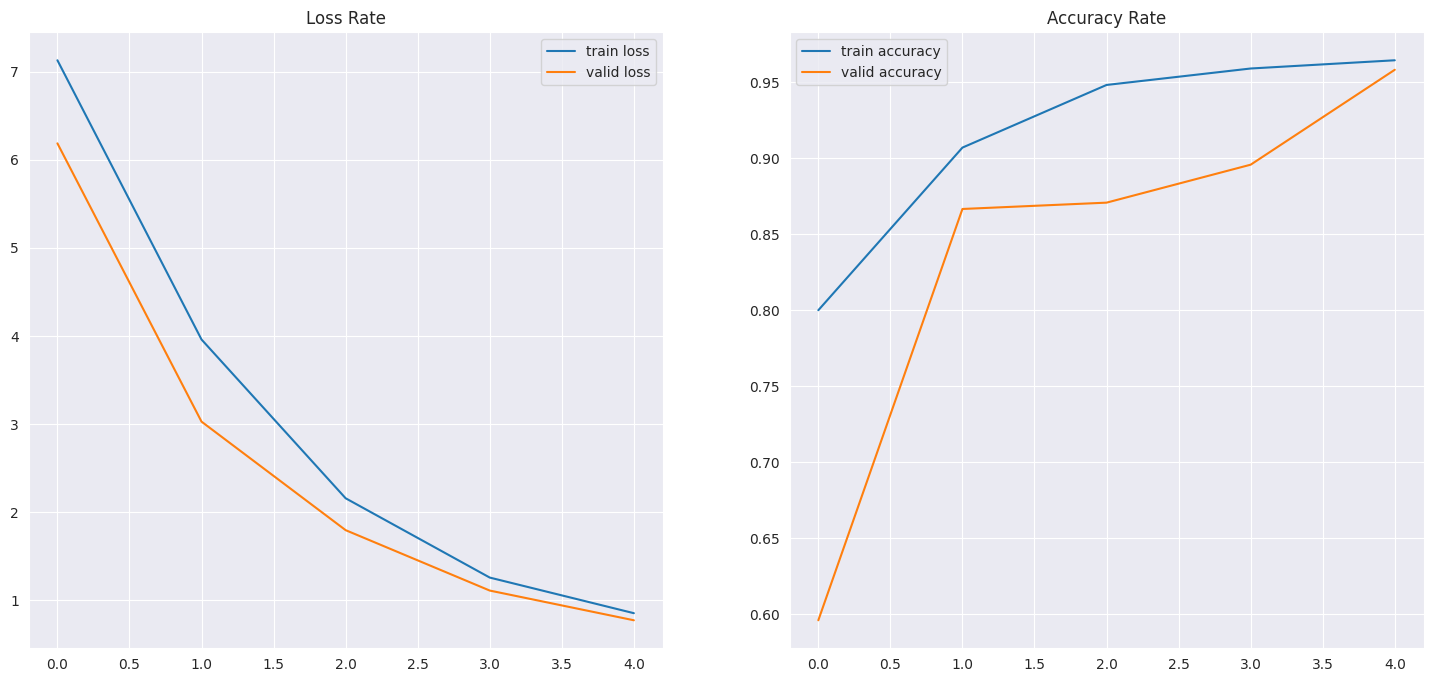

In [175]:
# Accuracy and Loss
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'],label='train loss')
plt.plot(hist.history['val_loss'],label='valid loss')
plt.title('Loss Rate')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'],label='train accuracy')
plt.plot(hist.history['val_accuracy'],label='valid accuracy')
plt.title('Accuracy Rate')
plt.legend()

plt.show()

In [176]:
# Model Evaluation
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

331/331 [==============================] - 38s 113ms/step - loss: 0.7394 - accuracy: 0.9517
Train Loss:  0.6604957580566406
Train Accuracy:  0.9888796806335449
--------------------
Validation Loss:  0.8194690346717834
Validation Accuracy:  0.9299848079681396
--------------------
Test Loss:  0.7393667697906494
Test Accuracy:  0.9516616463661194


In [177]:
# Prediction
batch_size = 100
Y_prob = model.predict(test_gen)
y_pred = np.argmax(Y_prob, axis=1)
print(y_pred)

331/331 [==============================] - 41s 119ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 3 2
 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 3 2 3 2
 2 2 2 3 2 2 3 3 2 2 2 2 3 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2
 3 2 2 2 3 2 2 2 2 3 2 2 2 3 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

In [178]:
# Confusion Matrix
cm = confusion_matrix(test_gen.classes, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap = plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[102   0   0   0   0   0]
 [  0 116   0   0   0   0]
 [  0   0 101  17   0   0]
 [  0   0   1 110   0   0]
 [  3   0   0   0 107   0]
 [  0   0   0   0  11  94]]


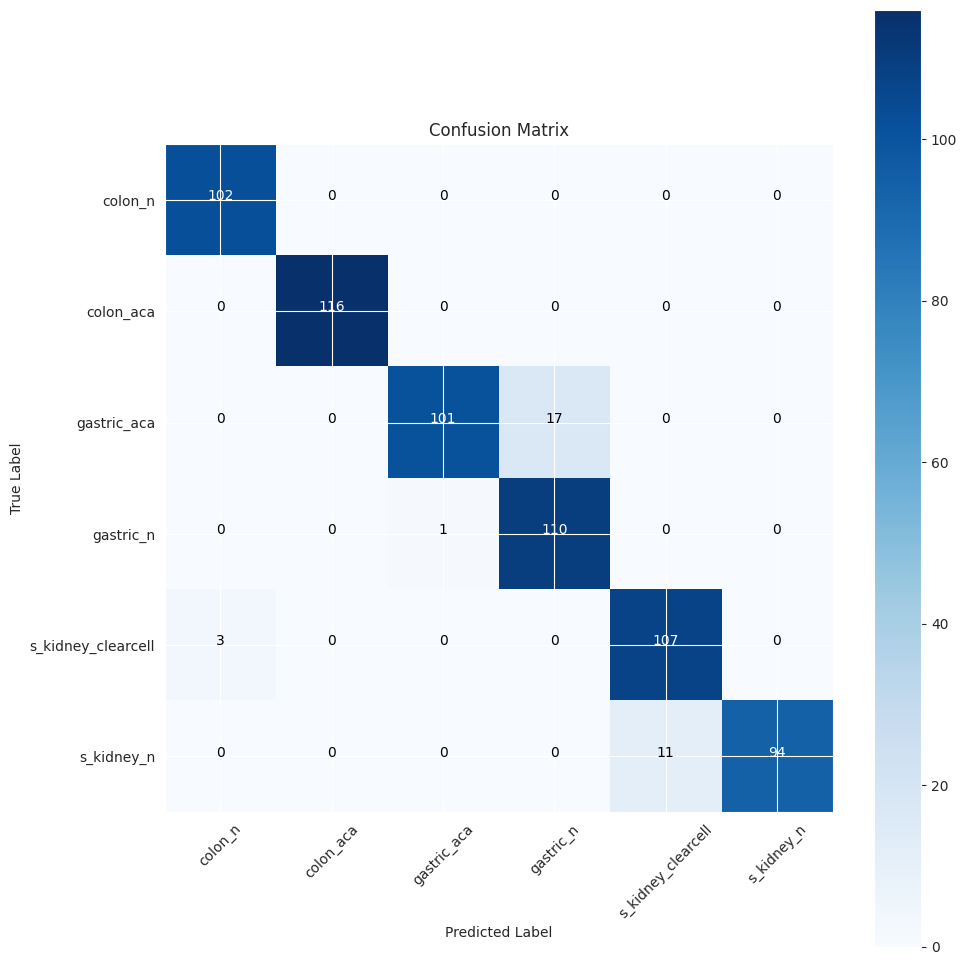

In [179]:
plot_confusion_matrix(cm=cm, classes=target_names, title = 'Confusion Matrix')

In [180]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

           colon_n       0.97      1.00      0.99       102
         colon_aca       1.00      1.00      1.00       116
       gastric_aca       0.99      0.86      0.92       118
         gastric_n       0.87      0.99      0.92       111
s_kidney_clearcell       0.91      0.97      0.94       110
        s_kidney_n       1.00      0.90      0.94       105

          accuracy                           0.95       662
         macro avg       0.96      0.95      0.95       662
      weighted avg       0.96      0.95      0.95       662



In [181]:
# Initialize an array to store the ROC AUC scores for each class
roc_auc_scores = []

from sklearn.metrics import roc_auc_score

# Calculate the ROC AUC score for each class
for i in range(len(target_names)):
    y_true = (np.array(test_gen.classes)== i).astype(int)
    y_score = Y_prob[:, i]
    roc_auc = roc_auc_score(y_true, y_score)
    roc_auc_scores.append(roc_auc)
    print(f"ROC AUC score for {target_names[i]}: {roc_auc}")

# Calculate the mean ROC AUC score across all classes
mean_roc_auc = np.mean(roc_auc_scores)
print(f"Mean ROC AUC score: {mean_roc_auc}")

ROC AUC score for colon_n: 0.9998949579831933
ROC AUC score for colon_aca: 1.0
ROC AUC score for gastric_aca: 0.9984733300099701
ROC AUC score for gastric_n: 0.9985611746047318
ROC AUC score for s_kidney_clearcell: 0.9968544137022398
ROC AUC score for s_kidney_n: 0.9997093271779088
Mean ROC AUC score: 0.9989155339130072


In [209]:
# #Save the model
# model.save('play_model.h5')

In [14]:
print(tf. __version__)

2.11.0
